(C) 2025, Gerold Baier, University College London

# Univariate Analysis of sEEG


## Import and Functions

In [9]:
from numpy import pi, linspace, sin, diff, arange, asarray, zeros, exp, array, linspace, flip

from matplotlib.pyplot import subplots

from scipy.signal import butter, sosfilt
from scipy.fft import rfft, rfftfreq

from pandas import read_csv


In [11]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start = 0
    samples = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means = data[start:start+samples, :electrodes].mean(axis=0)
    devs = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(8, 6))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    ax.set_yticklabels([]);

    return fig, ax


## Pick Patient, Seizure, Type, and read EEG


In [14]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '1'         # '1'
seizure     = '03'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' 


sr = 1000

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_100Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

print('')
print(series_chars)
print('')


../Data/Pat1_Sz03_Onset_1_100Hz.csv



In [16]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'A': [0, 11],
 'B': [11, 22],
 'C': [22, 31],
 'E': [31, 40],
 'F': [40, 49],
 'Z': [49, 56],
 'O': [56, 67],
 'T': [67, 74],
 'U': [74, 81],
 'V': [81, 92],
 'W': [92, 107],
 'X': [107, 122]}

In [20]:
all_labels[11:22]

Index(['B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9',
       'B9-B10', 'B10-B11', 'B11-B12'],
      dtype='object')

## Settings and Filtering


In [22]:
onset  = (146.7, 147.0, 146.7)


In [24]:
time_max = 60

init_cut  = 25

band_low  = 1
band_high = 20

order = 5

rows_max = int(time_max * sr)

sample_start = int((onset[int(seizure)-1]-30)*sr)
# sample_start = 0

sample_end = sample_start + rows_max

channel_start, channel_stop = 0, data_prefiltered.shape[1]  # Bad channels 81, 82 for 2015lvxiaofu

number_channels = channel_stop - channel_start


data_unfiltered = data_prefiltered[:, channel_start:channel_stop]


sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_unfiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(60000, 122)

# Complete EEG


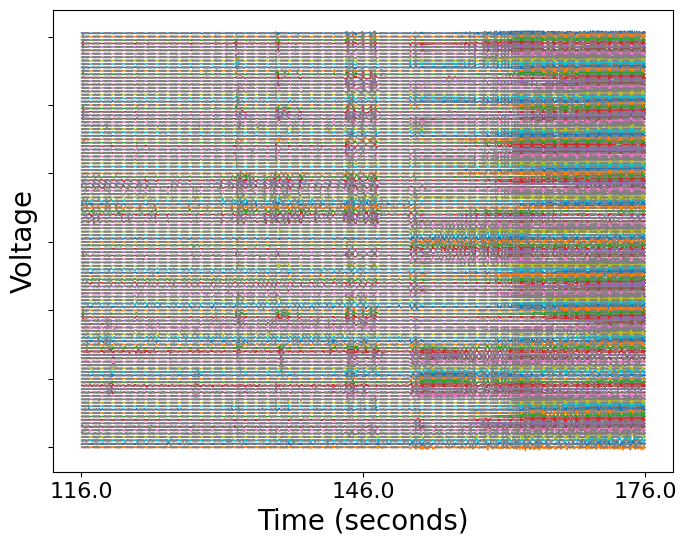

In [24]:
fig, ax = eeg_plot(data_filtered, 5)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

ax.set_ylabel('Voltage', fontsize=20);


# A Single Electrode


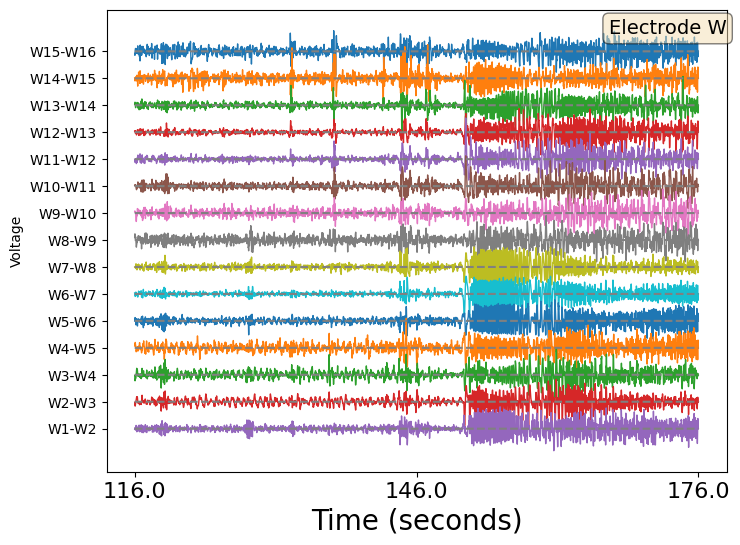

In [27]:
elec_name = 'W'

all_labels_np = asarray(all_labels)

elec_label_names = all_labels_np[label_dict[elec_name][0]:label_dict[elec_name][1]]

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]

chans = data_chan.shape[1]

factor = 5

fig, ax = eeg_plot(data_chan, factor, normalise=True)
ax.set_yticks(factor*arange(chans))
ax.set_yticklabels(elec_label_names)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
textstr = 'Electrode ' + elec_name
ax.text(0.81, 0.98, textstr, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props);


## Pick a Segment and Normalise

In [29]:
seg_start = 20000
seg_stop  = 50000

rows_seg = seg_stop - seg_start

data_chan_seg      = data_chan[seg_start:seg_stop, :]

means              = data_chan_seg.mean(axis=0)
devs               = data_chan_seg.std(axis=0)
data_chan_seg_norm = (data_chan_seg - means)/devs


## Time Series & Heatmap

figs/Sz03_W_timeseries_L1_H20_Start20000.png


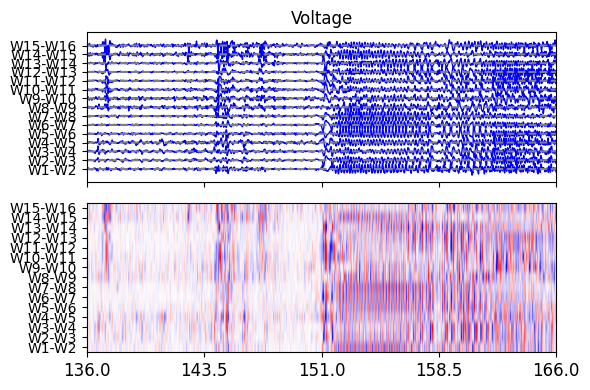

In [32]:
offset = 5

################################### Time Series
fig, (ax1, ax2) = subplots(nrows=2, figsize=(6,4))

### Voltage Series
ax1.plot(data_chan_seg_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax1.set_yticks(offset*arange(chans))
ax1.set_yticklabels(elec_label_names)
ax1.margins(x=0)
ax1.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax1.set_xticklabels([], fontsize=12)
ax1.set_title('Voltage', fontsize=12)


### Voltage Heatmap
ax2.imshow(data_chan_seg_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax2.set_yticks(arange(chans))
ax2.set_yticklabels(flip(elec_label_names));

ax2.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax2.set_xticklabels(labl, fontsize=12)


fig.tight_layout()

title_chars = 'figs/Sz' + seizure + '_' + elec_name + '_timeseries_' + 'L' + str(band_low) + '_H' + str(band_high) + '_Start' + str(seg_start) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)



Electrode A: during the seizure too regular, too big, too synchronised.


## Boxplots of Each Channel

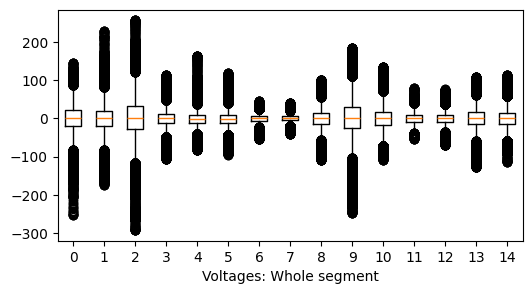

In [34]:
fig, ax = subplots(figsize=(6,3))

ax.boxplot(data_chan_seg);
ax.set_xlabel('Voltages: Whole segment')
ax.set_xticklabels(arange(chans));


## Histograms

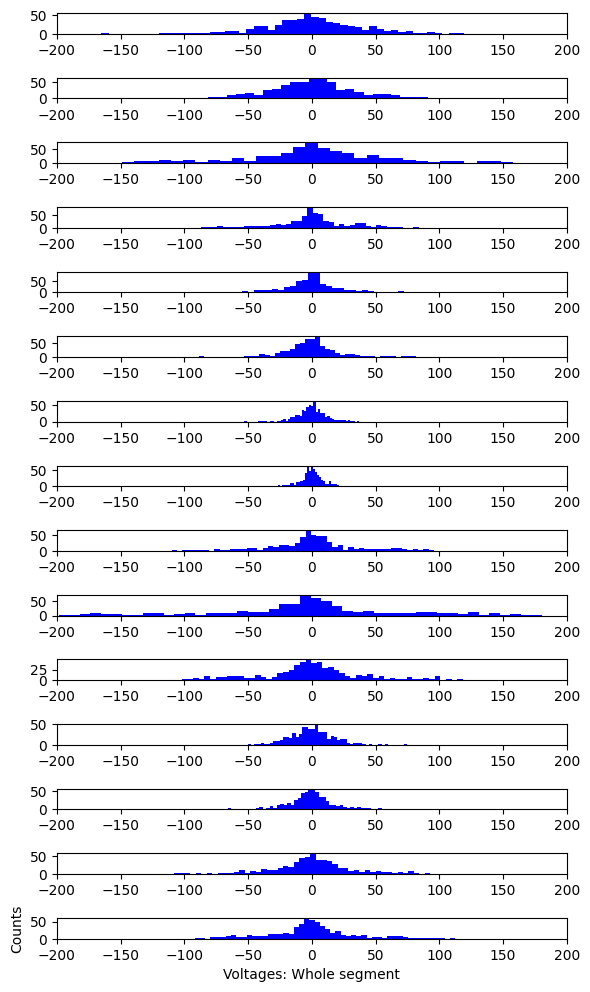

In [38]:
fig, ax = subplots(nrows=chans, figsize=(6,10))

bins = 50

for index in arange(chans):
    
    ax[index].hist(data_chan_seg[::50,index], bins=bins, color='b');
    ax[index].set_xlim(-200, 200)
    
ax[-1].set_xlabel('Voltages: Whole segment')
ax[-1].set_ylabel('Counts');

fig.tight_layout()


## The Fourier Spectrum

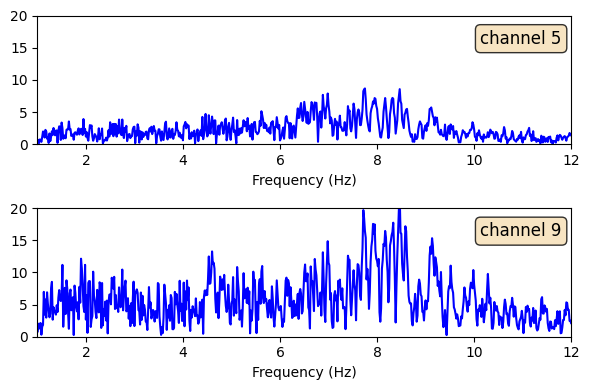

In [52]:
chan1, chan2 = 5, 9

ylim = 20

# frequencies
freqs = rfftfreq(rows_max, 1 / sr)

# amplitude
amplitudes = (2.0 / rows_max)*abs(rfft(data_filtered, axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes[:, chan1], c='b');
ax[0].set_xlim(1, 12);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes[:, chan2], c='b');
ax[1].set_xlim(1, 12);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan1)

ax[0].text(0.83, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan2)

ax[1].text(0.83, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()


## Boxplots & Histograms of Half Segments

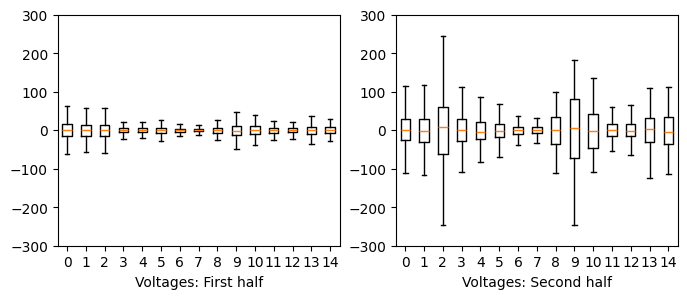

In [54]:
limit = 300

fig, ax = subplots(ncols=2, figsize=(8,3))

ax[0].boxplot(data_chan_seg[:rows_seg//2,:], showfliers=False);
ax[0].set_xticklabels(arange(chans))
ax[0].set_ylim(-limit, limit)

ax[0].set_xlabel('Voltages: First half')

ax[1].boxplot(data_chan_seg[rows_seg//2:,:], showfliers=False);
ax[1].set_xticklabels(arange(chans))
ax[1].set_ylim(-limit, limit)

ax[1].set_xlabel('Voltages: Second half');


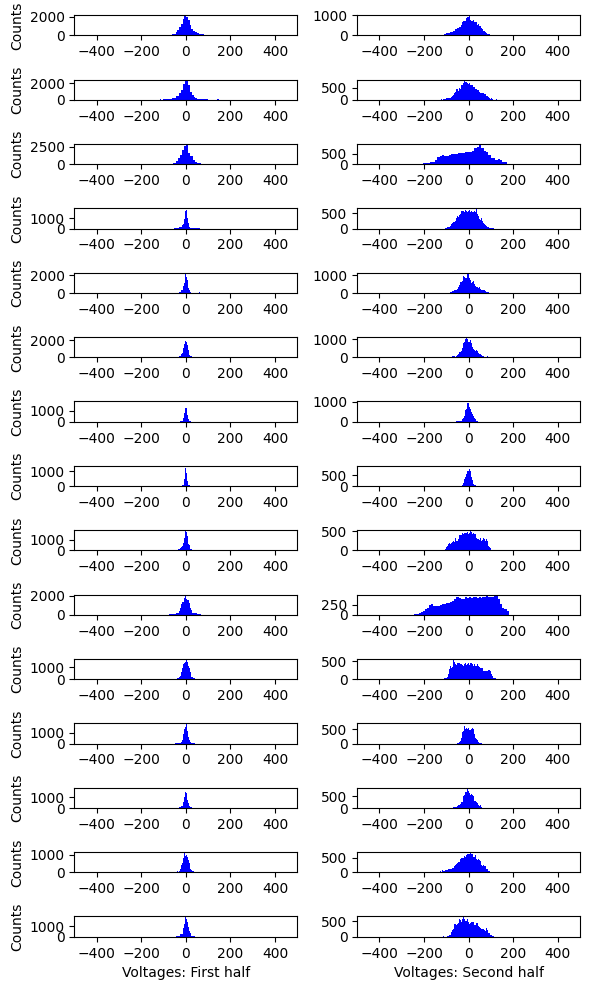

In [56]:
fig, ax = subplots(nrows=chans, ncols=2, figsize=(6,10))

for index in arange(chans):
    
    ax[index, 0].hist(data_chan_seg[:rows_seg//2,index], bins=bins, color='b');
    ax[index, 0].set_ylabel('Counts');
    ax[index, 1].hist(data_chan_seg[rows_seg//2:,index], bins=bins, color='b');
    ax[index, 0].set_xlim(-500, 500)
    ax[index, 1].set_xlim(-500, 500)

ax[-1, 0].set_xlabel('Voltages: First half')
ax[-1, 1].set_xlabel('Voltages: Second half')

fig.tight_layout()


## Fourier spectra of half segments

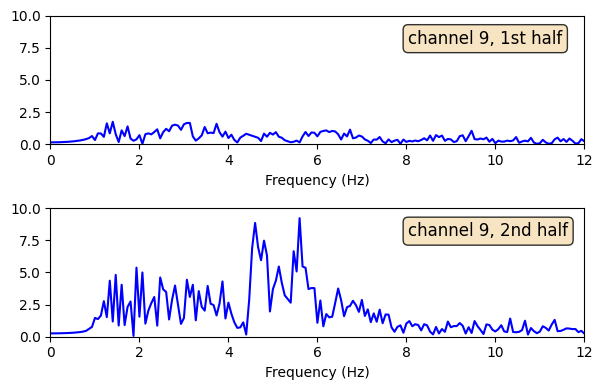

In [68]:
chan = 9 #9

ylim = 10

# frequencies
freqs = rfftfreq(rows_seg//2, 1 / sr)

# amplitude
amplitudes_1 = (2.0 / rows_max)*abs(rfft(data_chan_seg[:rows_seg//2, :], axis=0))
amplitudes_2 = (2.0 / rows_max)*abs(rfft(data_chan_seg[rows_seg//2:, :], axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes_1[:, chan], color='b');
ax[0].set_xlim(0, 12);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes_2[:, chan], color='b');
ax[1].set_xlim(0, 12);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan) + ', 1st half'

ax[0].text(0.67, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan) + ', 2nd half'

ax[1].text(0.67, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()


# Summary

- EEG is integral over extracellular currents in complex brain tissue (neurons, glia, blood vessels)
- EEG is organised in spatio-temporal patterns
- Normal Dynamics: irregular in frequency; small in amplitude; non-specific waveform
- Epileptic Dynamics: more regular frequency; often large amplitude; charactersitic waveforms.


# Try It Yourself

> Display data from different electrodes and pick different segments to re-run the code. You will be able to find segments with strongly contrasting types of dynamics. If you achieve to adjust the half segments, you will be able to maimise the contrast in univariate measures. 
